In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import open_clip
from torchvision import datasets, transforms
import torch
from PIL import Image
import open_clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn import calibration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.isotonic import IsotonicRegression as IR
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from util import get_preds, calc_bins, get_metrics, T_scaling, find_temp_scale, get_openai_prompts, get_val_set, find_temp_scale_with_q

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [18]:
model_name = 'ViT-B-32-quickgelu'
dataset_name = 'CIFAR100'
num_classes = 100
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion400m_e32', device=device)
tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
classes, templates = get_openai_prompts(dataset_name)
cifar_test.classes = classes

Files already downloaded and verified


In [19]:
val_dset = get_val_set(dataset_name, classes, preprocess)

Files already downloaded and verified


In [6]:
eces = []
mces = []
accs = []
for t in tqdm(templates):
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t)
    ece, mce, acc = get_metrics(predictions, actual, probs)
    eces.append(ece)
    accs.append(acc)
    mces.append(mce)

100%|██████████| 19/19 [02:12<00:00,  6.99s/it]


In [26]:
val_dset = get_val_set(dataset_name, classes, preprocess)
eces_scaled = []
mces_scaled = []
accs_scaled = []
temps = []
for t in tqdm(templates):
    scaled_temp = find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp)
    ece, mce, acc = get_metrics(predictions, actual, probs)
    eces_scaled.append(ece)
    accs_scaled.append(acc)
    mces_scaled.append(mce)
    temps.append(scaled_temp)

Files already downloaded and verified


100%|██████████| 19/19 [08:24<00:00, 26.54s/it]


Text(0.5, 1.0, 'ECE for different templates - ViT-B-32-quickgelu, CIFAR10')

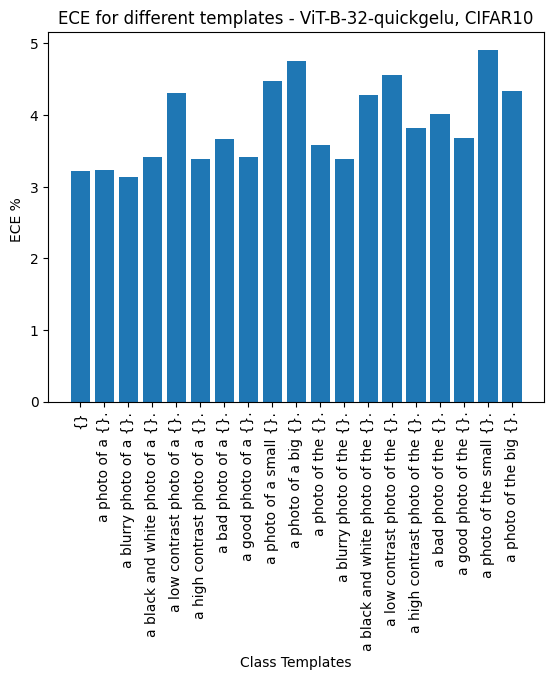

In [27]:
plt.bar(templates, np.array(eces) * 100.0)
plt.xticks(rotation=90)
plt.ylabel('ECE % ')
plt.xlabel('Class Templates')
plt.title(f'ECE for different templates - {model_name}, CIFAR10')

Text(0.5, 1.0, 'ECE for different templates - ViT-B-32-quickgelu, CIFAR10 - Temperature Scaled')

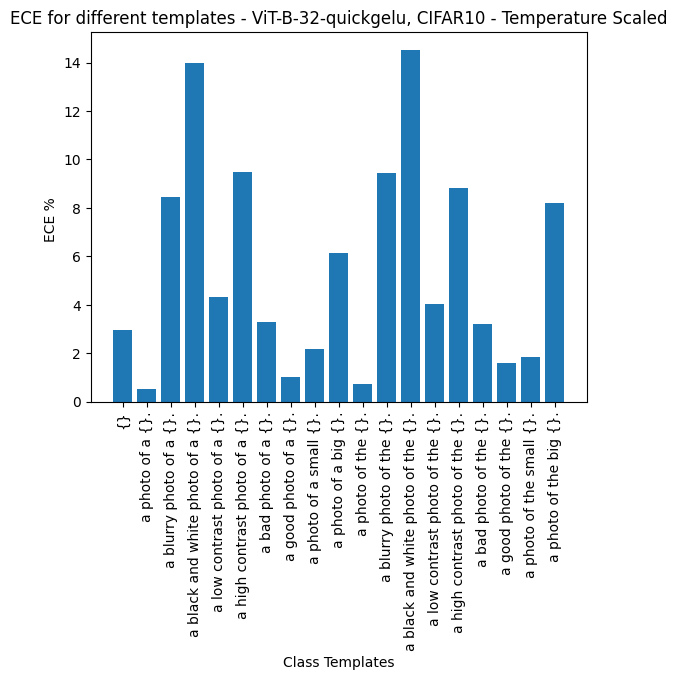

In [28]:
plt.bar(templates, np.array(eces_scaled) * 100.0)
plt.xticks(rotation=90)
plt.ylabel('ECE % ')
plt.xlabel('Class Templates')
plt.title(f'ECE for different templates - {model_name}, CIFAR10 - Temperature Scaled')

Text(0.5, 1.0, '% change in ECE after temperature scaling for different templates - ViT-B-32-quickgelu, CIFAR10')

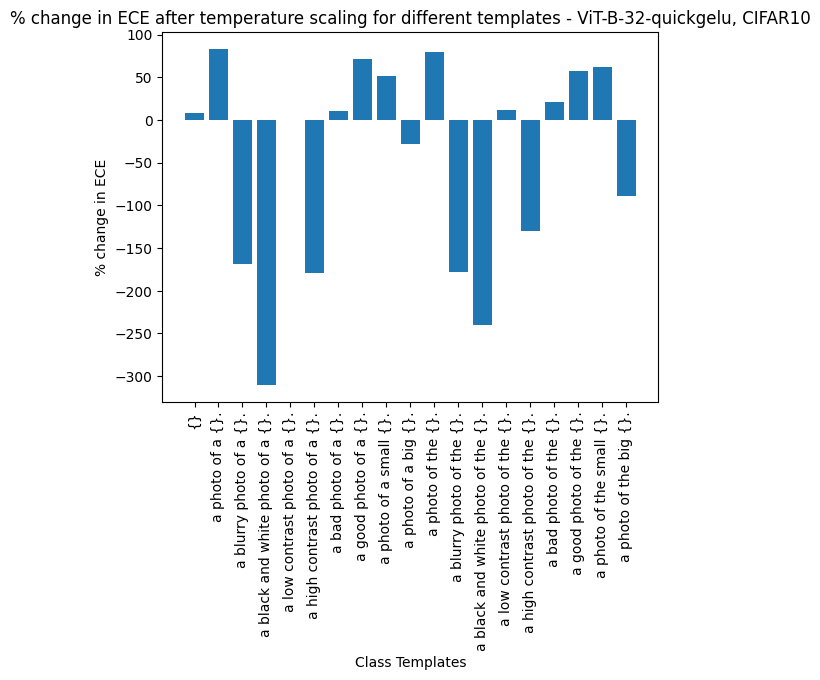

In [36]:
percs = []
for i in range(len(templates)):
    diff = (eces[i] - eces_scaled[i]) / eces[i] * 100.0
    percs.append(diff)
plt.bar(templates, percs)
plt.xticks(rotation=90)
plt.ylabel('% change in ECE')
plt.xlabel('Class Templates')
plt.title(f'% change in ECE after temperature scaling for different templates - {model_name}, CIFAR10')

In [56]:
pd.DataFrame({"ece" : eces, "ece after scaling" : eces_scaled}, index=templates)#.transpose()

,ece,ece after scaling
{},0.032146,0.029427
a photo of a {}.,0.032307,0.005388
a blurry photo of a {}.,0.031401,0.084436
a black and white photo of a {}.,0.034140,0.140037
a low contrast photo of a {}.,0.043075,0.043082
a high contrast photo of a {}.,0.033868,0.094709
a bad photo of a {}.,0.036625,0.032920
a good photo of a {}.,0.034173,0.009976
a photo of a small {}.,0.044690,0.021594
a photo of a big {}.,0.047572,0.061216


In [7]:
t = templates[1]
temp, text_probs = find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)

In [150]:
t = templates[3]
temp_black_and_white, text_probs = find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)

In [151]:
temp[0], temp_black_and_white[0]

(0.03371116518974304, 0.04430605471134186)

In [152]:
np.std(temp[-1]), np.std(temp_black_and_white[-1])

(0.3746635690856532, 0.3744867287368139)

(array([2.313e+03, 0.000e+00, 7.096e+03, 0.000e+00, 0.000e+00, 5.510e+02,
        0.000e+00, 3.900e+01, 0.000e+00, 1.000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

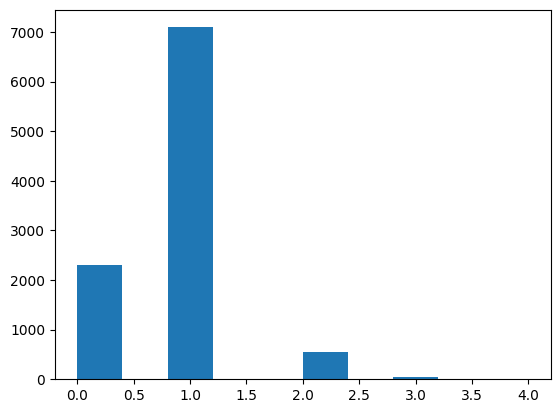

In [130]:
plt.hist(temp[-1])

In [119]:
    ## Get threshold
    q = 1 - 0.83 / 10
    text_probs_numpy = text_probs.cpu().numpy()

    logits_list = []
    labels_list = []
    confidences_of_js = np.sort(text_probs_numpy, axis=0)
    
    for j in range(len(text_probs_numpy[0])):
        confidences_of_j = confidences_of_js[:,j]
        thresh = confidences_of_j[int(len(confidences_of_j) * q)] 
        for k in range(len(text_probs_numpy)):
            if text_probs_numpy[k][j] >= thresh:
                logits_list.append(text_probs[k].unsqueeze(0))
                labels_list.append(j)
    
    logits_list = torch.cat(logits_list).to(device) # [len(dset), 100]
    labels_list = torch.FloatTensor(labels_list).to(device).long()

In [120]:
logits_list.shape, labels_list.shape, text_probs_numpy.shape

(torch.Size([8310, 10]), torch.Size([8310]), (10000, 10))

In [121]:
np.mean(logits_list.argmax(axis=1).cpu().numpy() == labels_list.cpu().numpy())

0.7861612515042118

In [ ]:
temp = 
lb_temps, lb_losses = temp[1], temp[2]
plt.subplot(121)
plt.plot(list(range(len(lb_temps))), lb_temps)
plt.xlabel('iteration')
plt.ylabel('Temperature')

plt.subplot(122)
plt.plot(list(range(len(lb_losses))), [x.item() for x in lb_losses])
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.suptitle(f'Training Temp for "{t}"')

Text(0.5, 0.98, 'Training Temp for "a photo of a {}."')

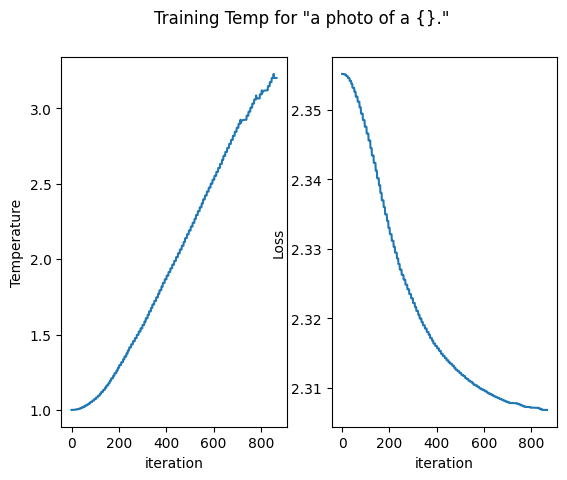

In [8]:
lb_temps, lb_losses = temp[1], temp[2]
plt.subplot(121)
plt.plot(list(range(len(lb_temps))), lb_temps)
plt.xlabel('iteration')
plt.ylabel('Temperature')

plt.subplot(122)
plt.plot(list(range(len(lb_losses))), [x.item() for x in lb_losses])
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.suptitle(f'Training Temp for "{t}"')

Text(0.5, 0.98, 'Training Temp for "a photo of a {}."')

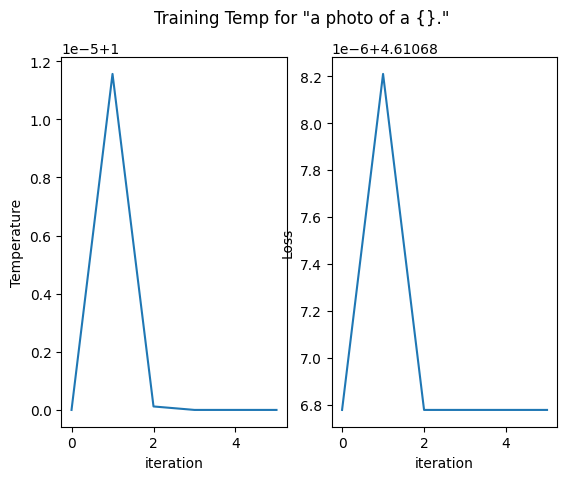

In [201]:
_, lb_temps, lb_losses, added = find_temp_scale_with_q(0, text_probs, device)
plt.subplot(121)
plt.plot(list(range(len(lb_temps))), lb_temps)
plt.xlabel('iteration')
plt.ylabel('Temperature')

plt.subplot(122)
plt.plot(list(range(len(lb_losses))), [x.item() for x in lb_losses])
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.suptitle(f'Training Temp for "{t}"')

In [197]:
eces_learned, temps_learned

([0.10710495156124233,
  0.10710495156124233,
  0.10710495156124233,
  0.10710495156124233],
 [1.0, 1.000011682510376, 1.0, 1.0000114440917969])

In [27]:
eces_learned = []
temps_learned = []
t = templates[0]
temp, text_probs = find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
x_axis = np.arange(0.96, 0.99, 0.005)
for q in tqdm(x_axis):
    scaled_temp = find_temp_scale_with_q(q, text_probs, device)
    temps_learned.append(scaled_temp)
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp)
    ece, mce, acc = get_metrics(predictions, actual, probs)
    eces_learned.append(ece)

100%|██████████| 7/7 [00:56<00:00,  8.09s/it]


Text(0, 0.5, 'Temp')

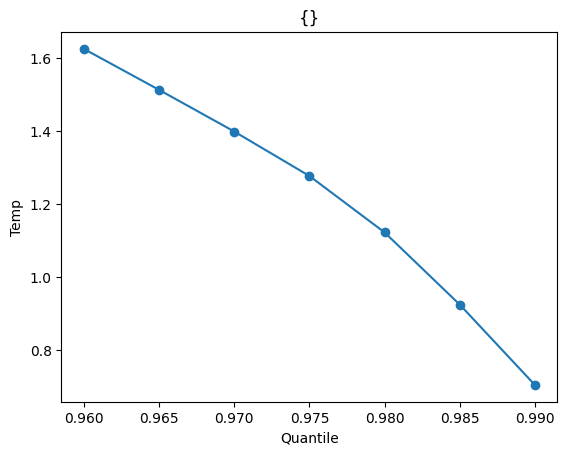

In [28]:
plt.plot(x_axis, temps_learned, marker='o')
plt.title(t)
plt.xlabel('Quantile')
plt.ylabel('Temp')

In [30]:
temps_learned[np.argmin(np.array(eces_learned))]

1.1229043006896973

Text(0.5, 0, 'Quantile')

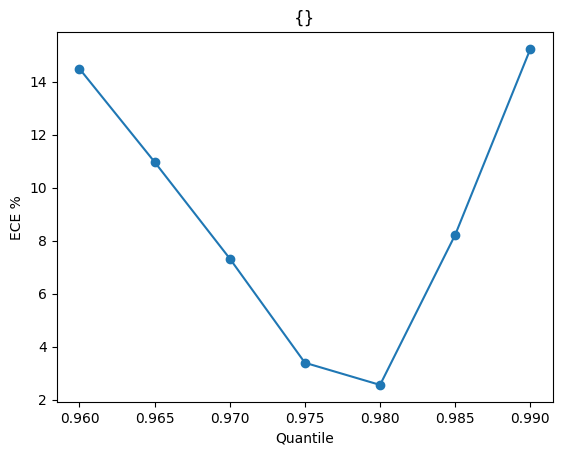

In [29]:
plt.plot(x_axis,np.array(eces_learned)*100, marker='o')
plt.title(t)
plt.ylabel('ECE %')
plt.xlabel('Quantile')

In [34]:
def func(n_classes):
    return 1 - (1.25 * np.log10(n_classes)) / n_classes
    
func(10), func(100)

(0.875, 0.975)

In [14]:
eces_learned

[0.17791948589235546,
 0.15609458043426275,
 0.13380684913098811,
 0.1107649007305503,
 0.08720373854637141,
 0.06348497666567568,
 0.03900301214158537,
 0.013608577755093578,
 0.013983888457715456,
 0.040771196854265425]

vary temperature directly

In [57]:
temps = np.arange(0.5, 3, 0.5)
eces_learned = []
for scaled_temp in tqdm(temps):
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp)
    ece, mce, acc = get_metrics(predictions, actual, probs)
    eces_learned.append(ece)

100%|██████████| 5/5 [00:37<00:00,  7.55s/it]


Text(0.5, 0, 'Temp')

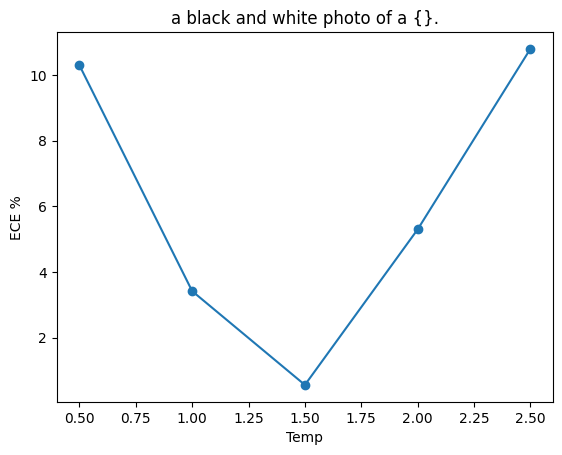

In [59]:
plt.plot(temps,np.array(eces_learned)*100, marker='o')
plt.title(t)
plt.ylabel('ECE %')
plt.xlabel('Temp')

CIFAR100

In [181]:
dataset_name = 'CIFAR100'
num_classes = 100
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
classes, templates = get_openai_prompts(dataset_name)
cifar_test.classes = classes

Files already downloaded and verified


In [32]:
eces_cifar100 = []
mces_cifar100 = []
accs_cifar100 = []
for t in tqdm(templates):
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t)
    ece, mce, acc = get_metrics(predictions, actual, probs)
    eces_cifar100.append(ece)
    accs_cifar100.append(acc)
    mces_cifar100.append(mce)

 21%|██        | 4/19 [00:34<02:08,  8.58s/it]


KeyboardInterrupt: 

In [ ]:
val_dset = get_val_set(dataset_name, classes, preprocess)
eces_scaled_cifar100 = []
mces_scaled_cifar100 = []
accs_scaled_cifar100 = []
temps_cifar100 = []
for t in tqdm(templates):
    scaled_temp = find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp)
    ece, mce, acc = get_metrics(predictions, actual, probs)
    eces_scaled_cifar100.append(ece)
    accs_scaled_cifar100.append(acc)
    mces_scaled_cifar100.append(mce)
    temps_cifar100.append(scaled_temp)